In [1]:
import pandas as pd
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_test_features = pd.read_csv(r'C:\Users\One\Git\ml-ds\as4\dota2_prediction\test_features.csv.zip', compression = 'zip', index_col='match_id_hash')


df_train_features  = pd.read_csv(r'C:\Users\One\Git\ml-ds\as4\dota2_prediction\train_features.csv.zip', compression = 'zip', index_col='match_id_hash')
df_train_targets  = pd.read_csv(r'C:\Users\One\Git\ml-ds\as4\dota2_prediction\train_targets.csv.zip', compression = 'zip', index_col='match_id_hash')

In [3]:
X = df_train_features.values
y = df_train_targets['radiant_win'].values

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=17)

In [5]:

model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17).fit(X_train, y_train)


In [6]:
y_pred = model.predict_proba(X_valid)[:, 1]

In [7]:
from sklearn.metrics import roc_auc_score

valid_score = roc_auc_score(y_valid, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.7772318342722802


In [8]:
from sklearn.metrics import accuracy_score

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print('Validation accuracy of P>0.5 classifier:', valid_accuracy)

Validation accuracy of P>0.5 classifier: 0.6974712257414097


In [9]:
X_test = df_test_features.values
y_test_pred = model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred}, 
                                 index=df_test_features.index)

In [10]:
import datetime
submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to submission_2019-11-15_14-52-11.csv


In [11]:
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=17)

In [12]:
model_rf1 = RandomForestClassifier(n_estimators=100, n_jobs=4,
                                   max_depth=None, random_state=17)

# calcuate ROC-AUC for each split
cv_scores_rf1 = cross_val_score(model_rf1, X, y, cv=cv, scoring='roc_auc')

In [13]:
%%time

model_rf2 = RandomForestClassifier(n_estimators=100, n_jobs=4,
                                   min_samples_leaf=3, random_state=17)

cv_scores_rf2 = cross_val_score(model_rf2, X, y, cv=cv, 
                                scoring='roc_auc', n_jobs=-1)

Wall time: 20.1 s


In [2]:
PATH_TO_DATA = 'C://'

import json

with open(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')) as fin:
    # read the 18-th line
    for i in range(18):
        line = fin.readline()
    
    # read JSON into a Python object 
    match = json.loads(line)

NameError: name 'os' is not defined

In [15]:
player = match['players'][2]

In [16]:
player['kills'], player['deaths'], player['assists']
player['ability_uses']
%matplotlib inline
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Gold change for all players')

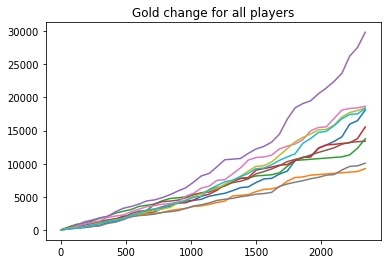

In [17]:
for player in match['players']:
    plt.plot(player['times'], player['gold_t'])
    
plt.title('Gold change for all players')

In [18]:
from tqdm import tqdm_notebook


def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

In [19]:
for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    game_time = match['game_time']
    
    # processing each game
    
    for player in match['players']:
        pass  # processing each player

In [20]:
def add_new_features(df_features, matches_file):
    
    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Counting ruined towers for both teams
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1

        # Write new features
        df_features.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills
        
        # ... here you can add more features ...

In [21]:
# copy the dataframe with features
df_train_features_extended = df_train_features.copy()

# add new features
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              'train_matches.jsonl'))

In [22]:
%%time

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, n_jobs=8, random_state=17)


Wall time: 0 ns


In [23]:
cv_scores_base = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
cv_scores_extended = cross_val_score(model, df_train_features_extended.values, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print('Base features: mean={} scores={}'.format(cv_scores_base.mean(), 
                                                cv_scores_base))
print('Extended features: mean={} scores={}'.format(cv_scores_extended.mean(), 
                                                    cv_scores_extended))

Base features: mean=0.7795738699757455 scores=[0.77723183 0.78656801 0.78004904 0.77732062 0.77669984]
Extended features: mean=0.7862340339233831 scores=[0.78570687 0.79044313 0.78708931 0.78227352 0.78565735]


In [24]:
%%time
# Build the same features for the test set
df_test_features_extended = df_test_features.copy()
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 'test_matches.jsonl'))

model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)
model.fit(X, y)
df_submission_base = pd.DataFrame(
    {'radiant_win_prob': model.predict_proba(df_test_features.values)[:, 1]}, 
    index=df_test_features.index,
)
df_submission_base.to_csv('submission_base_rf.csv')

model_extended = RandomForestClassifier(n_estimators=100, n_jobs=8, random_state=17)
model_extended.fit(df_train_features_extended.values, y)
df_submission_extended = pd.DataFrame(
    {'radiant_win_prob': model_extended.predict_proba(df_test_features_extended.values)[:, 1]}, 
    index=df_test_features.index,
)
df_submission_extended.to_csv('submission_extended_rf.csv')


Wall time: 48.5 s


In [25]:
import collections

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    ('lobby_type', lambda m: m['lobby_type']),
    ('objectives_len', lambda m: len(m['objectives'])),
    ('chat_len', lambda m: len(m['chat'])),
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    'x',
    'y',
    
    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'teamfight_participation',
    'towers_killed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
]

def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
            
    return collections.OrderedDict(row)
    
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

In [30]:
%%time

df_new_features = []
df_new_targets = []

for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    targets = extract_targets_csv(match, match['targets'])
    
    df_new_features.append(features)
    df_new_targets.append(targets)
    
df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
df_new_targets = pd.DataFrame.from_records(df_new_targets).set_index('match_id_hash')


Wall time: 1min 41s


In [3]:
import csv
import time
from collections import OrderedDict
from concurrent import futures
from contextlib import contextmanager
from itertools import chain
from itertools import islice
from pathlib import Path

import ujson as json
from tqdm import tqdm

PATH_TO_DATA = Path('../input')

MATCH_FEATURES = [
    ('game_mode', lambda m: m['game_mode']),
]

MATCH_FIELDS = [
    'match_id_hash', 'players', 'targets',
    'game_time', 'game_mode', 'lobby_type', 'objectives', 'chat'
]


PLAYER_FIELDS = [
    'hero_id',

    'kills',
    'deaths',
    'assists',
    'denies',

    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    'x',
    'y',

    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
]


def extract_features(match):
    match_id_hash = match['match_id_hash']
    row = [
        ('match_id_hash', match_id_hash),
        ('target', extract_targets(match)),
    ]
    append = row.append
    for field, f in MATCH_FEATURES:
        append((field, f(match)))
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = f'r{slot + 1}'
        else:
            player_name = f'd{slot - 4}'
        for field in PLAYER_FIELDS:
            append((f'{player_name}_{field}', player[field]))

        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1
        append(('r_tower_kills', radiant_tower_kills))
        append(('d_tower_kills', dire_tower_kills))
        append(('diff_tower_kills', radiant_tower_kills - dire_tower_kills))
    return OrderedDict(row)


def extract_targets(match):
    if 'targets' in match:
        return 1 if match['targets']['radiant_win'] else 0
    else:
        return ''


def extract_features_from_line(line):
    return extract_features(json.loads(line))


def read_lines(reader, offset, limit):
    for i, line in reader:
        if offset and i < offset:
            continue
        if limit and i >= offset + limit:
            return
        yield line


def get_chunks(iterable, size):
    iterator = iter(iterable)
    for first in iterator:
        yield chain([first], islice(iterator, size - 1))


def process(fin, fout, offset=0, limit=0, chunk_size=64):
    reader = iter(enumerate(fin))
    _, line = next(reader)
    features = extract_features(json.loads(line))
    fieldnames = tuple(features.keys())
    writer = csv.DictWriter(fout, fieldnames=fieldnames)
    writer.writeheader()
    if offset == 0:
        writer.writerow(features)
    chunks = get_chunks(tqdm(read_lines(reader, offset, limit), total=offset + limit or None), chunk_size)
    with futures.ProcessPoolExecutor() as pool:
        for features in chain.from_iterable(map(lambda x: pool.map(extract_features_from_line, x), chunks)):
            writer.writerow(features)


@contextmanager
def timer(name):
    print(f'[{name}]')
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.1f} s')


with timer('Extract features'):
    with (PATH_TO_DATA / 'train_matches.jsonl').open() as fin, open('train_matches.csv', 'w') as fout:
        process(fin, fout, limit=39675)
    with (PATH_TO_DATA / 'test_matches.jsonl').open() as fin, open('test_matches.csv', 'w') as fout:
        process(fin, fout, limit=10000)

ModuleNotFoundError: No module named 'ujson'